In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial import Delaunay
from scipy.spatial import Voronoi, voronoi_plot_2d

In [2]:
VP = np.array([np.inf, np.inf])

init_lines = [np.array([0, -1, 0]), np.array([-1, 0, 0]), np.array([0, 1, -1]), np.array([1, 0, -1])]

In [3]:
def adjMatrix(edges, N):
  """
  Return the adjacent matrix of given edges.

  Args:
    edges: the list of edges;
    N: the number of points;
  
  Returns:
    M: the adjacent matrix;
  """

  M = np.zeros((N, N))

  for edge in edges:
    i, j = edge
    M[i, j] = 1
    M[j, i] = 1

  return M

In [4]:
def homogeneousCoord(P):
  if len(P) == 2:
    return np.array([P[0], P[1], 1])

  return P

def inhomogeneousCoord(P):
  if len(P) == 3:
    if P[2] == 0:
      return VP
    return (P / (P[2]))[:2]
  
  return P

def pointLine(P, line):
  """
  Check whether point P lies in the right direction.

  Args:
    P: point;
    line: line parameter;
  
  Returns:
    ret: bool indicator;
  """

  if inhomogeneousCoord(P) is VP:
    return False
  
  if homogeneousCoord(P) @ line < 1e-7:
    return True
  
  return False

In [5]:
def convexHull(lines, init_points, init_lines):
  """
  Return the boundary points of the convex hull of P.

  Args:
    lines: the line parameters;
    points: the initial boundary points;
    init_lines: the initial line parameters;
  
  Returns:
    points: the boundary points of convex hull;
  """

  init_lines = init_lines.copy()
  init_points = init_points.copy()

  for line in lines:
    ## check current boundary points
    # for p in points:
    #   if homogeneousCoord(p) @ line > 0:
    #     points.remove(p)
    
    init_points = list(filter(lambda p: pointLine(p, line), init_points))

    ## find intersection of current line and previous lines
    # _points = []
    # for pl in init_lines:
    #   _p = np.cross(pl, line)
    #   _p = inhomogeneousCoord(_p)
    #   _points.append(_p)
    
    _points = list(map(lambda pl: inhomogeneousCoord(np.cross(pl, line)), init_lines))
    
    ## check intersections
    # for _p in _points:
    #   for pl in init_lines:
    #     if homogeneousCoord(_p) @ pl > 0:
    #       _points.remove(_p)
    #       break

    _points = list(filter(lambda _p: not (False in [pointLine(_p, il) for il in init_lines]), _points))
    
    init_lines.append(line)
    init_points = init_points + _points

  return init_points

In [6]:
def sortConvexHull(points):
  """
  Sort the convex hull boundary points.

  Args:
    points: convex hull boundary points;
  
  Returns:
    points: sorted convex hull boundary points;
  """

  N = len(points)
  
  for i in range(N):
    p = homogeneousCoord(points[i])
    for j in range(i+1, N):
      q = homogeneousCoord(points[j])
      l = np.cross(p, q)
      if False not in [pointLine(point, l) for point in points]:
        points[i+1], points[j] = points[j], points[i+1]
        break

  return points

In [7]:
def geoConvexHull(points):
  """
  Find the geometry center of a given convex hull.

  Args:
    points: convex hull boundary points;
  
  Returns:
    center: the geometry center;
  """

  N = len(points)
  P = points[0]

  center = np.zeros(2)
  area = 0

  for i in range(1, N-1):
    A = points[i]
    B = points[i+1]

    c = 1/3 * (P + A + B)
    a = np.abs(0.5 * np.cross(A-P, B-P))

    area += a
    center += c * a
  
  return center / area

In [8]:
def midLine(P, Q):
  """
  Find the mid line between P and Q and make sure that l @ P <= 0.

  Args:
    P: the point; 
    Q: another point;
  
  Returns:
    l: the mid line;
  """

  pq = Q - P
  mid = (P + Q) / 2

  l = np.array([pq[0], pq[1], -mid@pq])

  return l

In [9]:
def lloydCVT(vor, points, init_points=[], init_lines=init_lines):
  """
  One step of Lloyd algorithm.

  Args:
    vor:
    points: 
    init_points:
    init_lines:
  
  Returns:
    _points: the updated points coordinates;
  """
  M = adjMatrix(vor.ridge_points, N)
  _points = []

  for i in range(N):
    neighbors = M[i, :] > 0
    neighbors = np.arange(N)[neighbors]

    P = points[i]
    lines = [midLine(P, points[j]) for j in neighbors]

    bps = convexHull(lines, init_points, init_lines)
    bps = sortConvexHull(bps)

    _points.append(geoConvexHull(bps))
  
  return _points

In [10]:
def LloydCVT(points, steps=10):
  points = points.copy()
  vor = Voronoi(points)

  for i in range(steps):
    points = lloydCVT(vor, points)
    vor = Voronoi(points)
  
  return vor

# Experiment

## Original Voronoi Diagram

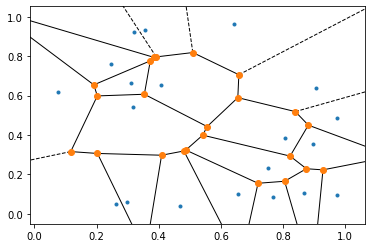

In [11]:
N = 20

points = np.random.rand(N, 2)
vor = Voronoi(points)

fig = voronoi_plot_2d(vor)

## Step = 1

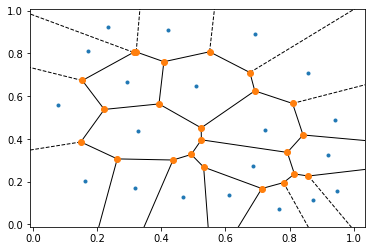

In [12]:
vor = LloydCVT(points, steps=1)
fig = voronoi_plot_2d(vor)

## Step = 2

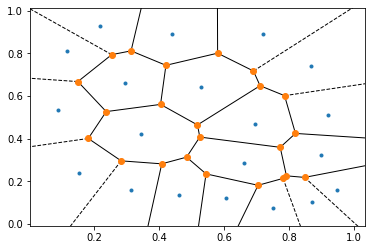

In [13]:
vor = LloydCVT(points, steps=2)
fig = voronoi_plot_2d(vor)

## Step = 3

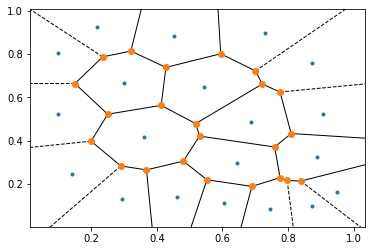

In [14]:
vor = LloydCVT(points, steps=3)
fig = voronoi_plot_2d(vor)

## Step = 4

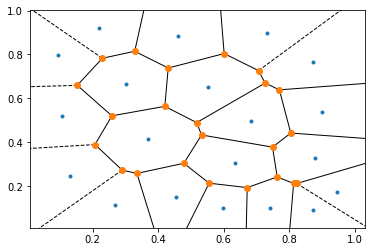

In [15]:
vor = LloydCVT(points, steps=4)
fig = voronoi_plot_2d(vor)

## Step = 5

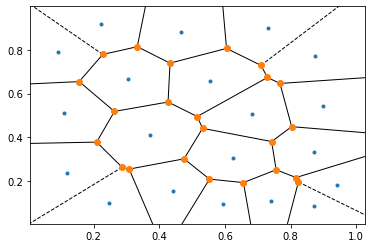

In [16]:
vor = LloydCVT(points, steps=5)
fig = voronoi_plot_2d(vor)

## Step = 10

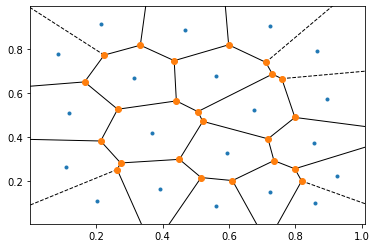

In [17]:
vor = LloydCVT(points, steps=10)
fig = voronoi_plot_2d(vor)

## Step = 20

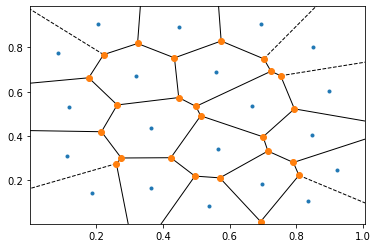

In [18]:
vor = LloydCVT(points, steps=20)
fig = voronoi_plot_2d(vor)

## Step = 50

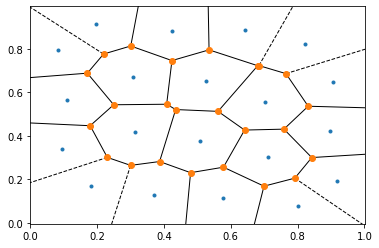

In [19]:
vor = LloydCVT(points, steps=50)
fig = voronoi_plot_2d(vor)

## Step = 100

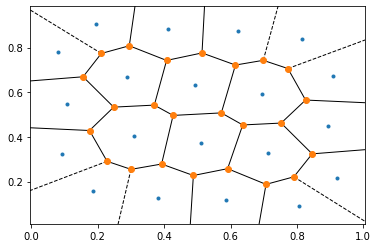

In [20]:
vor = LloydCVT(points, steps=100)
fig = voronoi_plot_2d(vor)